In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
using Test
using ForwardDiff
using NLsolve
using Distributions
using BenchmarkTools
using LoopVectorization

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

In [4]:
Nx = 3
Ne = 500

X0 = randn(Nx, Ne) .^2 .* (1.0 .+ 0.3*randn(Nx, Ne))
X = deepcopy(X0)
X .+= 0.1*randn(Nx, Ne)
B = MultiBasis(CstProHermite(6), Nx)
idx = [0 0 0 ;0  0 1; 0 1 0; 1 0 0;1 1 0; 10 1 1; 1 5 1; 4 6 3; 1 2 0; 4 1 0]
Nψ = size(idx, 1)
coeff = randn(Nψ)

f = ExpandedFunction(B, idx, coeff)
fp = ParametricFunction(f);
R = IntegratedFunction(fp)
S = Storage(fp, X);

In [15]:
Nx = 100
m = 20
Ne = 500
Xprior = randn(Nx, Ne).*randn(Nx, Ne)
Xpert = deepcopy(Xprior .+ 0.3*randn(Nx, Ne))

M = HermiteMap(m, Xprior; diag = true)
optimize(M, Xprior, 5; withconstant = false);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


In [16]:
Xpost = deepcopy(Xpert)
Xhybrid = deepcopy(Xpert)

F = evaluate(M, Xprior)
inverse!(Xpost, copy(F), M)

hybridinverse!(Xhybrid, copy(F), M)

@test norm(Xprior - Xpost)/norm(Xpost)<1e-6

@test norm(Xprior - Xhybrid)/norm(Xprior)<1e-6

Test Passed

┌ Warning: /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent is not an existing directory, Revise is not watching
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:565


In [14]:
evaluate(M, Xpost)

100×500 Array{Float64,2}:
  0.822935   -0.263992     0.117899   …   0.786344     0.111981    0.526208
 -0.155294   -0.337694    -0.969846      -0.850076    -0.439233   -0.513792
  0.97452     0.130456    -0.428311      -0.554197    -0.562652    1.08353
 -0.29877    -1.27727     -0.446924       1.45386      0.970215   -0.356623
  0.288212    0.0166396    0.0805585      1.78045      1.34838    -0.455331
  1.05496    -1.99025      0.369452   …  -1.5383      -1.20615     0.854571
  0.228983   -1.88854     -0.0937185     -2.31672     -4.51455     0.435131
  0.0318051   0.00536244  -0.880724       0.745397     0.608634   -0.181827
  0.0807029   1.8784      -0.406168       0.0967476   -0.076947   -0.203739
  0.805181   -0.443086     0.821051      -2.05628     -0.497363    0.276948
  0.341332    0.269184     0.0287198  …   0.527084     0.232049   -0.0834802
 -0.302737   -0.126461    -0.268721      -1.8551       1.03632    -0.693643
 -0.177393    0.624568     0.0188061      0.915033    -0.02194

In [70]:
evaluate(M, Xpost)[36,:]

500-element Array{Float64,1}:
  0.4783942213508641
 -0.6703872484237725
  2.862064375283519
  0.1625380213240352
  1.1960179141289293
  0.07991124790283566
 -0.009172069591303206
  1.3000143219523215
 -0.9424785886643875
 -0.15880011785905593
 -0.1714369028134791
  0.8597110852635682
  0.10568485673404127
  ⋮
  0.56351761836208
  0.07721998315104006
 -1.3240447068550494
  1.282902574954873
  2.2887766114139203
 -0.5106274209192392
  1.5195192544140417
  1.6792790449558153
  0.20608851274522083
 -0.8979951865533644
  0.018659300793244134
 -2.6417151603210414

In [73]:
findmax(evaluate(M, Xprior)[36,:]-evaluate(M, Xpost)[36,:])

(7.078782005009998e-13, 323)

In [61]:
Xprior[36,21]

0.4387525983724838

In [62]:
Xpost[36,21]

1.2652219675138383

In [58]:
findmax(abs.(evaluate(M, Xpost)-evaluate(M, Xprior)))

(0.7588015123810957, CartesianIndex(36, 21))

In [36]:
@testset "Test inversion of the Hermite Map I" begin
    using Test
    Nx = 100
    m = 20
    Ne = 500
    Xprior = randn(Nx, Ne).*randn(Nx, Ne)
    Xpost = deepcopy(Xprior) .+ 0.3*randn(Nx, Ne)

    M = HermiteMap(m, Xprior; diag = true)
    optimize(M, Xprior, 5; withconstant = false)

    F = evaluate(M, Xprior)
    inverse!(Xpost, F, M)

    @test norm(Xprior - Xpost)/norm(Xpost)<1e-6
end


@testset "Test inversion of the Hermite Map II" begin

    Nx = 100
    Ny = 50
    m = 20
    Ne = 500
    Xprior = randn(Nx, Ne).*randn(Nx, Ne)
    Xpost = deepcopy(Xprior) .+ 0.2*randn(Nx, Ne)

    M = HermiteMap(m, Xprior; diag = true)
    Ystar = deepcopy(Xpost[1:Ny,:])# + 0.05*randn(Ny,Ne);

    M = HermiteMap(m, Xprior)
    optimize(M, Xprior, 5; withconstant = false, start = Ny+1)

    F = evaluate(M, Xpost; start = Ny+1)
    inverse!(Xprior, F, M, Ystar; start = Ny+1, P = serial)

    @test norm(evaluate(M, Xprior; start = Ny+1)-evaluate(M, Xpost; start = Ny+1))/norm(evaluate(M, Xpost; start = Ny+1))<1e-6

    @test norm(Xprior[Ny+1:end,:] - Xpost[Ny+1:end,:])/norm(Xpost[Ny+1:end,:])<1e-6
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Test inversion of the Hermite Map I: Test Failed at In[36]:15
  Expression: norm(Xprior - Xpost) / norm(Xpost) < 1.0e-6
   Evaluated: 0.008424282633755964 < 1.0e-6
Stacktrace:
 [1] top-level scope at In[36]:15
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at In[36]:2
Test Summary:                       | Fail  Total
Test inversion of the Hermite Map I |    1      1


LoadError: [91mSome tests did not pass: 0 passed, 1 failed, 0 errored, 0 broken.[39m

In [10]:
@testset "Test inversion of the Hermite Map I" begin
    using Test
    Nx = 100
    m = 20
    Ne = 500
    Xprior = randn(Nx, Ne).*randn(Nx, Ne)
    Xpost = deepcopy(Xprior) .+ 0.3*randn(Nx, Ne)

    M = HermiteMap(m, Xprior; diag = true)
    optimize(M, Xprior, 5; withconstant = false)

    F = evaluate(M, Xprior)
    inverse!(Xpost, F, M)

    @test norm(Xprior - Xpost)/norm(Xpost)<1e-6
end


@testset "Test inversion of the Hermite Map II" begin

    Nx = 100
    Ny = 50
    m = 20
    Ne = 500
    Xprior = randn(Nx, Ne).*randn(Nx, Ne)
    Xpost = deepcopy(Xprior) .+ 0.2*randn(Nx, Ne)

    M = HermiteMap(m, Xprior; diag = true)
    Ystar = deepcopy(Xpost[1:Ny,:])# + 0.05*randn(Ny,Ne);

    M = HermiteMap(m, Xprior)
    optimize(M, Xprior, 5; withconstant = false, start = Ny+1)

    F = evaluate(M, Xpost; start = Ny+1)
    inverse!(Xprior, F, M, Ystar; start = Ny+1, P = serial)

    @test norm(evaluate(M, Xprior; start = Ny+1)-evaluate(M, Xpost; start = Ny+1))/norm(evaluate(M, Xpost; start = Ny+1))<1e-6

    @test norm(Xprior[Ny+1:end,:] - Xpost[Ny+1:end,:])/norm(Xpost[Ny+1:end,:])<1e-6
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


Test inversion of the Hermite Map I: Error During Test at In[10]:1
  Got exception outside of a @test
  UndefVarError: fa not defined
  Stacktrace:
   [1] hybridinverse!(::SubArray{Float64,2,Array{Float64,2},Tuple{UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}, ::SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.Slice{Base.OneTo{Int64}}},true}, ::IntegratedFunction, ::Storage; niter::Int64, ϵx::Float64, ϵf::Float64, P::Serial) at /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent/hybridinverse.jl:138
   [2] #hybridinverse!#150 at /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent/hybridinverse.jl:220 [inlined]
   [3] inverse!(::Array{Float64,2}, ::Array{Float64,2}, ::HermiteMap; apply_rescaling::Bool, P::Serial) at /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent/hermitemap.jl:509
   [4] inverse!(::Array{Float64,2}, ::Array{Float64,2}, ::HermiteMap) at /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent/hermitemap.jl:494
   [5] top-level scope at In[10]:13
   [6] to

LoadError: [91mSome tests did not pass: 0 passed, 0 failed, 1 errored, 0 broken.[39m

In [221]:
@btime begin
    Nx = 3
    Ne = 500

    X0 = randn(Nx, Ne) .^2 .* (1.0 .+ 0.3*randn(Nx, Ne))
    X = deepcopy(X0)
    X .+= 0.1*randn(Nx, Ne)
    B = MultiBasis(CstProHermite(6), Nx)
    idx = [0 0 0 ;0  0 1; 0 1 0; 1 0 0;1 1 0; 10 1 1; 1 5 1; 4 6 3; 1 2 0; 4 1 0]
    Nψ = size(idx, 1)
    coeff = randn(Nψ)

    f = ExpandedFunction(B, idx, coeff)
    fp = ParametricFunction(f);
    R = IntegratedFunction(fp)
    S = Storage(fp, X)

    F0 = evaluate(R, X0)
    F = copy(F0)
end

  368.364 μs (458 allocations: 2.55 MiB)


500-element Array{Float64,1}:
 -0.2602884952716751
 -0.37789969547884916
  1.623157253785775
 -0.7318148846966601
 -0.791493610480654
  6.902987721701352
 -0.3796503621444539
  2.0028609675126754
  4.58751147385926
  0.62905006229955
  7.87108352894949
 -0.34306968988612446
 -0.5565017170334313
  ⋮
 -0.28812843665418963
  0.8414144987829988
 -0.4206455761872232
  0.24067055349914823
 -1.8349912058473867
 -0.7091574503344977
 -0.833897772305442
 -1.3894055819226456
  0.14307735024960744
 -0.8596756722876994
 -1.1417363718596565
  1.2908678385351262

In [220]:
@btime begin
    Nx = 3
    Ne = 500

    X0 = randn(Nx, Ne) .^2 .* (1.0 .+ 0.3*randn(Nx, Ne))
    X = deepcopy(X0)
    X .+= 0.1*randn(Nx, Ne)
    B = MultiBasis(CstProHermite(6), Nx)
    idx = [0 0 0 ;0  0 1; 0 1 0; 1 0 0;1 1 0; 10 1 1; 1 5 1; 4 6 3; 1 2 0; 4 1 0]
    Nψ = size(idx, 1)
    coeff = randn(Nψ)

    f = ExpandedFunction(B, idx, coeff)
    fp = ParametricFunction(f);
    R = IntegratedFunction(fp)
    S = Storage(fp, X)

    F0 = evaluate(R, X0)
    F = copy(F0)
    inverse!(X, F, R, S)
end

  1.047 ms (1131 allocations: 3.84 MiB)


500-element view(::Array{Float64,2}, 3, :) with eltype Float64:
 -0.04272001917072685
  0.17448041150550256
 -0.019978575260491013
  0.27953011081056783
  2.231941031813527
  0.14322845145751417
  0.30399748222054096
 -0.04076316321523114
  0.293242804433407
 -0.017398517287347637
  3.311480981018346
  0.4470945712820416
  0.9133695005863243
  ⋮
  2.400079124914213
  1.003272983423846
  0.018477836918372424
  3.603842806443272
  0.6670533306813241
  0.36555850370430887
  0.23278395945582211
  1.5238877163185187
  0.5425981015053213
  0.954634776602408
  0.13089525636927327
  2.634270404169508

In [180]:
F0 = evaluate(R, X0)
F = copy(F0)
@btime inverse!(X, F, R, S)

  0.001185 seconds (673 allocations: 1.291 MiB)


500-element view(::Array{Float64,2}, 3, :) with eltype Float64:
 0.25140415843276703
 1.2541689648760388
 2.978335713815538
 0.48800507516111774
 2.518369415777971
 0.08511767436719533
 0.2646318449158077
 0.1324287101401709
 0.12997433460050326
 1.6382197947874977
 1.2825790972437234
 0.5108899508313886
 0.07131692306673115
 ⋮
 0.12414837461992498
 0.21043498188406395
 1.6660893993389956
 0.43278288639453416
 1.1131892377141734
 2.3244983547673304
 2.9657339676407917
 0.7994896145542376
 1.0116555864142796
 4.920678082350647
 0.3147014683475653
 0.6154219792894643

In [108]:
F = evaluate(R, X)-F0

500-element Array{Float64,1}:
 -6.661338147750939e-16
  2.220446049250313e-16
  0.0
  0.0
  0.0
  0.0
  0.0
 -2.220446049250313e-16
  2.220446049250313e-16
  0.0
 -2.220446049250313e-16
  0.0
  6.661338147750939e-16
  ⋮
 -4.440892098500626e-16
 -2.220446049250313e-16
  4.440892098500626e-16
  0.0
  4.440892098500626e-16
  2.220446049250313e-16
  2.220446049250313e-16
  4.440892098500626e-16
  0.0
 -8.881784197001252e-16
 -2.220446049250313e-16
 -6.661338147750939e-16

In [96]:
xrange = -3.0:0.01:3.0

Xrange = repeat(randn(Nx), 1, length(xrange))
Xrange[end, :] .= collect(xrange);

Frange = evaluate(R, Xrange);

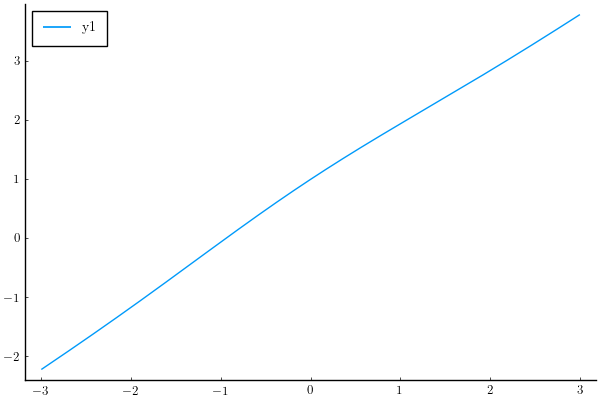

In [95]:
plot(xrange, Frange) 

In [79]:
F = evaluate(R, X)-F0

500-element Array{Float64,1}:
  4.440892098500626e-16
  2.0416966732828e-5
  5.507756629974381e-5
  0.0003553838927192743
 -2.22939015670498e-6
  0.001112745410920768
 -0.00013209668325542268
  0.00180256120876221
  7.149428470931696e-5
  0.0019392624119554114
  4.730865202251522e-5
  0.0014024719731007274
 -0.00018059255608315894
  ⋮
  1.665248307691769e-6
 -2.142023073137267e-6
  2.2190510269304298e-6
  0.0009421867783019344
 -3.5736089135429694e-5
  4.618112118492945e-6
  2.9039895784954695e-5
  0.0001826890869240927
  0.0005444951828030842
  0.0015304040382493334
  0.00015649811774665068
  8.4668072841243e-5

In [51]:
F = evaluate(R, X0);

cache  = zeros(Ne, Nψ)
cache_vander = zeros(Ne, maximum(R.f.f.idx[:,Nx])+1)
fx = zeros(Ne)

# Remove f(x_{1:k-1},0) from the output F
@avx for i=1:Ne
    foffseti = zero(Float64)
    for j=1:Nψ
        foffseti += (S.ψoffψd0[i,j])*R.f.f.coeff[j]
    end
    F[i] -= foffseti
end

# lower and upper brackets of the ensemble members
xk = view(X, Nx, :)
xm = copy(xk)
xp = copy(xk)
σ = std(xm)
@show σ
xm .-= 0.5*σ
xp .+= 0.5*σ
fm = zeros(Ne)
fp = zeros(Ne)
# Find a bracket for the different samples
niter = 1000
factor = 1.6
counter = 0
bracketed = false
while bracketed == false
    functionalf!(fm, xm, cache, cache_vander, S.ψoff, F, R)
    functionalf!(fp, xp, cache, cache_vander, S.ψoff, F, R)
    # We know that the function is strictly increasing
    if all(fm .< 0.0) && all(fp .> 0.0)
        bracketed = true
        break
    end
    @inbounds for i=1:Ne 
        if fm[i]*fp[i] > 0.0
            counter += 1
            center, width = 0.5*(xp[i] + xm[i]), factor*(xp[i] - xm[i])
            xm[i] = center - width
            xp[i] = center + width
        end
    end
    counter += 1
end

@assert counter < niter "Maximal number of iterations reached"

ϵxpm = 1e-6

xnew = copy(xk)
xold = copy(xk)
J = zero(fx)
xpm = maximum(xp .- xm)
@show 1.0, xpm
# while xpm > ϵxpm
for j=1:10
#     copy!(xold, xnew)

    # Compute the Newton update
    functionalf!(fx, xnew, cache, cache_vander, S.ψoff, F, R)
    functionalg1D!(J, xnew, cache, cache_vander, S.ψoff, F, R)
    @inbounds for i=1:Ne
        xnewi = xnew[i]
        xoldi = xold[i]
        fxi   = fx[i]
        Ji    = J[i]
        xmi   = xm[i]
        fmi   = fm[i]
        xpi   = xp[i]
        fpi   = fp[i]
        
        xpmi = abs(xpi - xmi)
        @show xpmi
        if xpm < xpmi
            xpm = xpmi
        end
        
        # Check if xnewton is within the bracket, otherwise apply bisection
        if xnewi > xpi || xnewi < xmi
            
        # Apply the bisection method
        xnewi, fxi, xmi, fmi, xpi, fpi = bisection(xnewi, fxi, xmi, fmi, xpi, fpi)
        @show xmi <= xnewi <= xpi
        
#         # Decrease too slowly, revert to bisection
#         elseif abs(fxi * 2.0) > abs(Δxi* Ji)
#         # Apply the bisection method
#         xnewi, fxi, xmi, fmi, xpi, fpi = bisection(xnewi, fxi, xmi, fmi, xpi, fpi)
                
#         elseif abs(Ji) < 1000*eps()
#         # Apply bisection
                              
#         else #Apply Newton update
#         xnew[i] -= fxi/Ji
        end
        
        xnew[i] = xnewi
        xold[i] = xoldi
        xm[i]   = xmi
        fm[i]   = fmi
        xp[i]   = xpi
        fp[i]   = fpi
    end
    @show xpm
end

σ = 0.28377625473180507
(1.0, xpm) = (1.0, 0.28377625473180507)
xpmi = 0.28377625473180507
xpmi = 0.283776254731805
xpmi = 0.283776254731805
xpm = 0.28377625473180507
xpmi = 0.28377625473180507
xpmi = 0.283776254731805
xpmi = 0.283776254731805
xpm = 0.28377625473180507
xpmi = 0.28377625473180507
xpmi = 0.283776254731805
xpmi = 0.283776254731805
xpm = 0.28377625473180507
xpmi = 0.28377625473180507
xpmi = 0.283776254731805
xpmi = 0.283776254731805
xpm = 0.28377625473180507
xpmi = 0.28377625473180507
xpmi = 0.283776254731805
xpmi = 0.283776254731805
xpm = 0.28377625473180507
xpmi = 0.28377625473180507
xpmi = 0.283776254731805
xpmi = 0.283776254731805
xpm = 0.28377625473180507
xpmi = 0.28377625473180507
xpmi = 0.283776254731805
xpmi = 0.283776254731805
xpm = 0.28377625473180507
xpmi = 0.28377625473180507
xpmi = 0.283776254731805
xpmi = 0.283776254731805
xpm = 0.28377625473180507
xpmi = 0.28377625473180507
xpmi = 0.283776254731805
xpmi = 0.283776254731805
xpm = 0.28377625473180507
xpmi = 0.

In [32]:
fm

100-element Array{Float64,1}:
 -0.5756596087792389
 -0.1678154206031459
 -0.6088356830332864
 -0.5209664235922674
 -0.09237300788343977
 -0.006520460441294451
 -0.003515166212953419
 -0.05699144797568545
 -0.11798454374018785
 -0.12739579137438342
 -0.08505119625299146
 -0.1000711139362156
 -0.6198949168683905
  ⋮
 -0.2544199792203823
 -0.02774511050486894
 -0.25343152504506805
 -0.10990158361627142
 -0.5057558755323068
 -0.14761742673830983
 -0.17688996942740703
 -0.12493319846427609
 -0.10464604802200322
 -0.08888383043096149
 -0.15633743167498654
 -0.21706139084201892

In [34]:
@time optimize(S, X, "kfolds"; withqr = true, hessprecond = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


116.187149 seconds (12.75 M allocations: 143.489 GiB, 4.39% gc time)


HermiteMap(20, 10, LinearTransform(10, [1.1195256465682104, 0.9728805809361984, 0.915577381173001, 0.9169390552688318, 1.024849057653465, 1.0207711546991929, 1.071957519333033, 0.9829474984141241, 1.0037238471249987, 1.0422161865737807], [2.45918785711432 0.0 … 0.0 0.0; 0.0 2.2539117629083045 … 0.0 0.0; … ; 0.0 0.0 … 2.30972952436834 0.0; 0.0 0.0 … 0.0 2.2509787353294453], true), MapComponent[Map component of dimension 1 with Nψ 14 active features
, Map component of dimension 2 with Nψ 16 active features
, Map component of dimension 3 with Nψ 20 active features
, Map component of dimension 4 with Nψ 20 active features
, Map component of dimension 5 with Nψ 19 active features
, Map component of dimension 6 with Nψ 20 active features
, Map component of dimension 7 with Nψ 20 active features
, Map component of dimension 8 with Nψ 20 active features
, Map component of dimension 9 with Nψ 20 active features
, Map component of dimension 10 with Nψ 20 active features
])

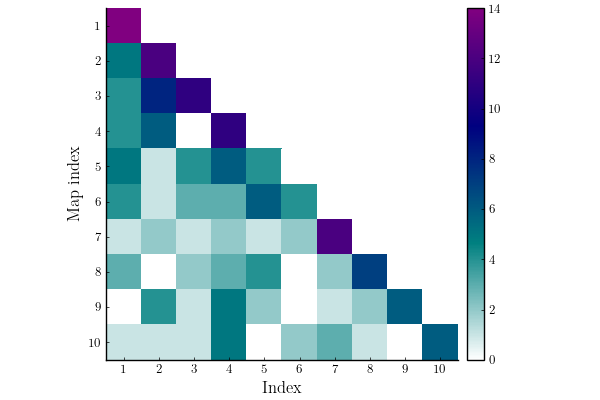

In [35]:
plot(S)

In [36]:
F = rand(Laplace(), (Nx, Ne))
F0 = deepcopy(F);

In [37]:
xrange = -5:0.01:5.0

Xrange = zeros(Nx, length(xrange))
Xrange[end,:] .= collect(xrange)
view(Xrange,1:Nx-1,:) .= repeat(randn(Nx-1), 1, length(xrange));

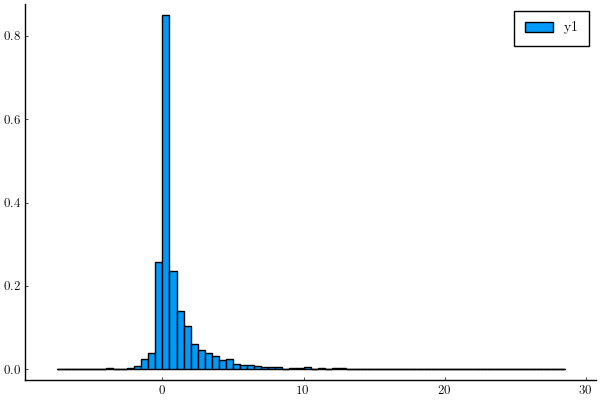

In [38]:
histogram(sort(X[end,:]),  bins = 90, normalize = :pdf)

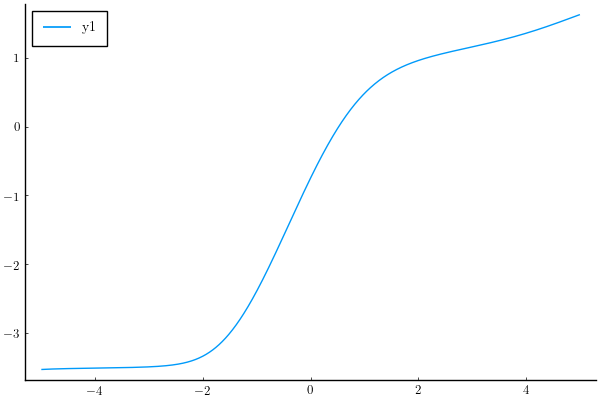

In [39]:
plot(xrange, evaluate(S, Xrange; start = Nx)[end,:])

In [123]:
Xpost = deepcopy(X)[:,1:1]
@btime inverse!(Xpost, copy(F[:,1:1]), S)

  233.605 μs (4289 allocations: 267.03 KiB)


10×1 Array{Float64,2}:
 -6.6940053024980894
  0.7813151227451507
 -0.1545225018963985
  1.5829584025685157
 -0.2182828264926049
  1.6811151650045222
  0.36005280775071213
  0.6414972076521022
  0.9728650754039316
 -0.5096409881052824

In [125]:
Xpost = deepcopy(X)
@btime inverse!(Xpost, copy(F), S)

  10.562 ms (12123 allocations: 20.68 MiB)


10×500 Array{Float64,2}:
 -6.69432    -0.325811  0.866688   …   3.99049    0.800305   -5.34821
  0.652841    1.00699   0.0709028      0.119864   0.782312    0.332934
 -0.147232    1.01834   0.130148       0.203138  -0.409091    0.863126
  1.56178     0.235563  1.70613        1.21226    0.264081    1.91235
 -0.217985    5.13841   0.250809       0.572872   0.837754   -0.478516
  1.65968    -0.510001  0.795841   …   2.53737    0.0704323   8.82153
  0.0676075  -0.318584  0.725396       1.13007   -0.111888    0.171928
  0.643154    0.987011  1.4607        -0.231542   1.15277     0.125883
  0.971018   -0.361035  1.51833        0.520839   2.40892    -5.70749
 -0.510841    0.269097  0.435094       0.625539   8.08316     0.330348

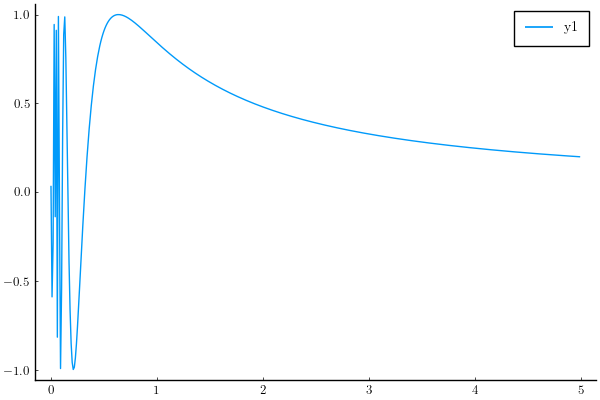

In [16]:
plot(collect(0.00001:0.01:5.0), sin.(1 ./ collect(0.00001:0.01:5.0)))

In [63]:
maximum(evaluate(S, Xpost)-F)

0.007631680483031644

In [108]:
@btime ψoff = evaluate_diagbasis(S[10].I.f, X)

  18.940 μs (40 allocations: 142.86 KiB)


500×14 Array{Float64,2}:
 0.617909     0.183069     -0.398576  1.0  …   0.236137     1.0  -0.257108
 0.00151744   0.00745327    0.024813  1.0      0.242059     1.0   0.360888
 0.605522     0.248767     -0.355901  1.0      0.302956     1.0  -0.176634
 0.630959     0.0407927    -0.444291  1.0      0.0557021    1.0  -0.3483
 0.630153     0.0607466    -0.441445  1.0      0.0826658    1.0  -0.342476
 0.230572     0.462921      0.494154  1.0  …  -0.382899     1.0  -0.101714
 0.606173     0.245843     -0.358126  1.0      0.300328     1.0  -0.180717
 0.41352      0.538263      0.20302   1.0      0.0455764    1.0   0.355185
 0.615824     0.196001     -0.391343  1.0      0.250444     1.0  -0.243147
 0.365527     0.540657      0.307002  1.0     -0.103223     1.0   0.301408
 0.631619     0.000146277  -0.446622  1.0  …   0.000200298  1.0  -0.353086
 0.44251      0.527922      0.132449  1.0      0.134593     1.0   0.355307
 0.631619    -0.00013236   -0.446622  1.0     -0.000181241  1.0  -0.353086
 ⋮

In [68]:
?nlsolve

search: nlsolve NLsolve NonlinearSolve EnsembleSolution EnsembleTestSolution



No documentation found.

`NLsolve.nlsolve` is a `Function`.

```
# 4 methods for generic function "nlsolve":
[1] nlsolve(df::Union{NLSolversBase.NonDifferentiable, OnceDifferentiable}, initial_x::AbstractArray; method, xtol, ftol, iterations, store_trace, show_trace, extended_trace, linesearch, linsolve, factor, autoscale, m, beta, aa_start, droptol) in NLsolve at /home/mat/.julia/packages/NLsolve/gJL1I/src/nlsolve/nlsolve.jl:1
[2] nlsolve(f, initial_x::AbstractArray; method, autodiff, inplace, kwargs...) in NLsolve at /home/mat/.julia/packages/NLsolve/gJL1I/src/nlsolve/nlsolve.jl:40
[3] nlsolve(f, j, initial_x::AbstractArray; inplace, kwargs...) in NLsolve at /home/mat/.julia/packages/NLsolve/gJL1I/src/nlsolve/nlsolve.jl:56
[4] nlsolve(f, j, fj, initial_x::AbstractArray; inplace, kwargs...) in NLsolve at /home/mat/.julia/packages/NLsolve/gJL1I/src/nlsolve/nlsolve.jl:70
```
